## Genetic Algorithm 

In this notebook, we implement a new selection operator (tournament selection) and a new cost function (for the Goodwin oscillator).  At the end, there is also code to plot the parameters as they change over the generations.

In [79]:
import matplotlib.pyplot as plt
import numpy as np
import os.path
import scipy.linalg
import scipy.integrate
import scipy.signal
import matplotlib.cm

### Support function for GA
Copy-paste your copy of generateIndividual, generateChild, and GA below.

In [80]:
def generateIndividual(cost_fcn, lb,ub):
    '''
    Generate a viable individual (i.e one whos cost function is finite)
    and return it and its cost.
    If 1000 tries fails to yield an individual, then the paramets and an infinite cost
    are returned.
    Each individual is generated by randomly chosing each entry params[i] 
    so that lb[i] <= params[i] <= ub[i]
    Input:
        cost_fcn: handle to the cost function (which should take a candidate as input)
        lb: lower bounds for parameters (array of length NP)
        ub: upper bounds for parameters (array of length NP)
    Returns:
        (params, cost)
        where params is the same shape as the lower bounds
        and cost is the cost for that set of parameters
    '''
    params = np.zeros(lb.shape);
    cost   = np.inf;
    for i in range( 1000 ):
        params = lb + np.multiply( np.random.random(lb.size), ub-lb);
        cost   = cost_fcn(params);
        if np.isfinite(cost):
            return (params, cost);
    return (params, np.inf)

def generateChild(cost_fcn, P, lb, ub, settings):
    """
    Generate a viable child (i.e one whos cost function is finite)
    and return it and its cost function.
    If 1000 tries fails to yield a parent, then an infinite cost
    is returned.
    Input Parameters:
        cost_fcn: handle to the cost function (which should take a candidate as input)
        P: parents (lam x NP ndarray of parameter values)
        lb: lower bounds for parameters (array of length NP)
        ub: upper bounds for parameters (array of length NP)
        settings: a GASettings object
    Returns:
        (params, cost)
        where params is the same shape as the lower bounds
        and cost is the cost for that set of parameters
    """
    params = np.zeros(lb.shape);
    cost   = np.inf;
    for i in range(1000):
        # Choose two parenst from the breeding pool.
        P1idx = np.random.choice(P.shape[0]);
        P1  = P[P1idx,:];
        P2idx = np.random.choice(P.shape[0]);
        P2  = P[P2idx,:];
        for j in range(lb.size):
            # uniform cross-over
            if np.random.random() < 0.5:
                params[j] = P1[j];
            else:
                params[j] = P2[j];
        # Mutate optimization variables
        params = np.multiply( 1+np.random.randn(params.size)*settings.mutation, params);
        # Make sure the mutation hasn't moved us out of bounds
        params = np.maximum(params,lb);
        params = np.minimum(params,ub);
        cost   = cost_fcn(params);
        if np.isfinite(cost):
            return ( params, cost );
    return (np.zeros((lb.size)), np.inf)

def GA(cost_fcn, lb, ub, settings):
    """ Run the algorithm described in the notes to find a low-cost
        population of parameter sets.
        Input:
            cost_fcn: handle to cost function (should take a paramer set as input)
            lb: lower bounds for parameters (numpy array of length NP)
            ub: lower bounds for parameters (numpy array of length NP)
            settings: GASettings object
        Returns
            (params, cost, all_params, all_costs)
            where 
            params is a 1xNP vector with the best parameter set found
            cost is a scalar with the cost of the best parameter set
            all_params is a list with a (settings.numChildren x NP) ndarray of parameters for each generation
            all_costs is a list with an NP-length array of costs for each generation
    """

    mu = settings.numParents;
    lam = settings.numChildren;
    numGenerations = settings.numGenerations;

    # Create initial population
    G = np.zeros( (lam,lb.size) );
    Gcost = np.zeros( (lam,) );
    for i in range(lam):
        (G[i,:], Gcost[i]) = generateIndividual(cost_fcn, lb, ub);
    # sort them by cost
    idx   = np.argsort(Gcost);
    Gcost = Gcost[idx]
    G     = G[idx,:];
    all_params = [G]
    all_costs = [Gcost]

    for g in range(numGenerations):
        # Promote any elites
        elites = G[:settings.eliteCount,:]
        eliteCosts = Gcost[:settings.eliteCount]
        # select breeding pool
        (P, Pcost) = select_pool( G, Gcost, settings )
        # Generate the children for generation g
        G = np.zeros((lam, lb.size));
        Gcost = np.zeros((lam,));
        G[:settings.eliteCount,:] = elites
        Gcost[:settings.eliteCount] = eliteCosts
        for i in range(settings.eliteCount,lam):
           (G[i,:], Gcost[i]) = generateChild(cost_fcn, P, lb, ub, settings); 
        # sort the children of this generation
        idx   = np.argsort(Gcost);
        Gcost = Gcost[idx]
        G     = G[idx,:];
        print('Best of generation ', g+1, ' has cost ', Gcost[0]);
        all_params.append(G)
        all_costs.append(Gcost)

    params = G[0,:];
    cost   = Gcost[0];
    return (params, cost, all_params, all_costs)

## Update code to include linear ranking selection

Copy-paste your GASettings definition and add to it a field named linearRankingRatio. Give it a default value of 4.

In [103]:
class GASettings:
    def __init__( self, numParents = 10, numChildren = 50 ):
        self.numParents = numParents;
        self.numChildren = numChildren;
        self.numGenerations = 5;
        self.selection = 'truncation'; 
        self.mutation = 0.05; # std of normal distribution computed as mutation*value
        self.eliteCount = 1;
        self.tournamentSize = 2; 
        self.linearRankingRatio = 4;

Copy-paste your select_pool below. Add to it support for linear ranking selection (call it "linearRanking").

In linear rankng selection, we compute a discrete probability distribution with the probability of each individual in the previous generation being chosen for the breeding pool. The probabilities are constructed so that the probability of choosing the lowest-cost individual is settings.linearRankingRatio times the probability of choosing the highest cost individual. For each individual we want to add to the pool we use this probability distribution by choosing a number from a uniform distribution between 0 and 1 and then determining which index in the cumulative distribution is the smallest such that the cumulative distribution is larger than the random number.

The algorithm is this. If $n$ is the number of individuals in the previous generation and $r$ is the linearRankingRatio, then we construct the probability distribution according to

<ul>
<li> $p_n = \left(\frac{2}{n}\right)\left(\frac{1}{1+r}\right)$
<li> $p_1 = r \cdot p_n$
<li> Make an ndarray <tt>ps</tt> of length n. (so $ps[0]$ will hold $p_1$)
<li>for i in 1:n+1:
<ul>
<li>$ps[i-1] = p_n + (p_1-p_n)\frac{n-i}{n-1}$
</ul>
<li> Make the ndarray <tt>cs</tt> of the cumulative distribution by calling <tt>cumsum</tt>
</ul>

And selection individuals in the breeding pool

<ul>
<li>For each individual to select to the pool
<ul>
<li>num = number chosen from uniform distribution from 0 to 1
<li>idx = index of first element of <tt>cs</tt> that is greater than num
<li>Choose the idxth individual from the previous generation
</ul>
</ul>

In [97]:
def select_pool( G, Gcost, settings ):
    """ Select a breding pool from the previous generation.
    G is numChildren x numParameters
    Gcost is numChildren long and is sorted in ascending order.
    Returns (P,Pcost)
    where 
    P is numParents x numParameters
    Pcost is numParents long.
    """
    if Gcost.size != settings.numChildren:
        print("problem")
        return
    P = np.zeros( (settings.numParents,G.shape[1]) )
    Pcost = np.zeros( (settings.numParents,) )
    Pidxs = []
    if settings.selection == 'truncation':
        for i in range(settings.numParents):
            idx = np.random.choice(settings.numParents)
            P[i,:] = G[idx,:]
            Pcost[i] = Gcost[idx]

    elif settings.selection == 'uniform':
        for i in range(settings.numParents):
            idx = np.random.choice(G.shape[0])
            P[i,:] = G[idx,:]
            Pcost[i] = Gcost[idx]

    elif settings.selection == 'tournament':
        for i in range( settings.numParents ):
            idxs = np.random.choice(G.shape[0], (settings.tournamentSize,) )
            # pick the best one, which is smaller index (since costs sorted)
            idx = idxs.min()
            P[i,:] = G[idx,:]
            Pcost[i] = Gcost[idx]
    elif settings.selection == 'linearRanking':
        r = settings.linearRankingRatio
        n = settings.numChildren
        pn = 2/n*(1/(1+r))
        p1 = r*pn
        ps = np.zeros((n,))
        for i in range(1,n+1):
            ps[i-1] = pn + (p1-pn)*(n-i)/(n-1)
        cs = ps.cumsum()

        for i in range( settings.numParents ):
            num = np.random.random() # number between 0 and 1, from uniform distribution
            idx = np.argmax( num < cs )
            P[i,:] = G[idx,:]
            Pcost[i] = Gcost[idx]
    
    else:
        print( "Unknown selection operator: ", settings.selection )
    return (P, Pcost)

## Test the selection operators

This includes code that demonstrates the distribution of costs in the pool when selecting with linear ranking selection (ratios of 4 and 8) and tournament selection (tournament sizes of 2 and 5).

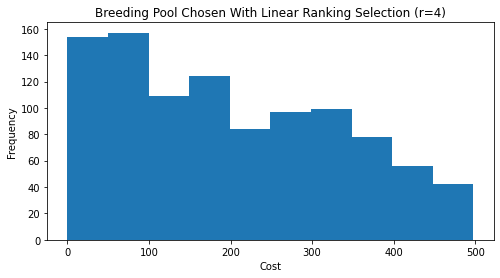

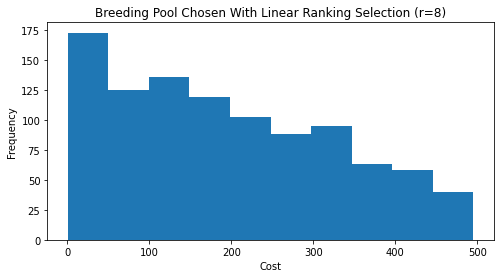

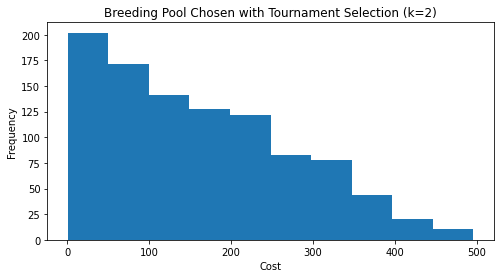

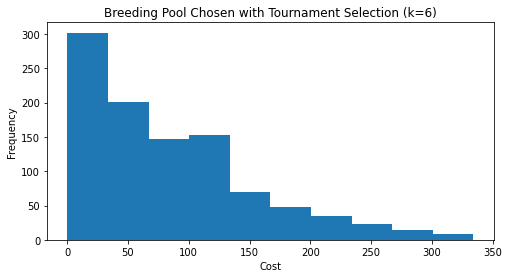

In [129]:
# Test the selection operators
# Make fake parameters, using the index as the values (so we can differentiate them)
lam = 10000 # number of individuals in generation
mu = 1000 # number of individuals in breeding pool
NP = 5 # num of parameters per individual
G = np.zeros( (lam,NP) )
for i in range(lam):
    G[i,:] = i
Gcost = np.linspace(0.1,500,lam)
settings = GASettings(numParents=mu, numChildren=lam)

settings.selection = 'linearRanking'
settings.linearRankingRatio = 4
(P, Pcost) = select_pool(G, Gcost, settings)
plt.figure( figsize=(8,4) )
plt.hist( Pcost );
plt.title( "Breeding Pool Chosen With Linear Ranking Selection (r=4)")
plt.xlabel( 'Cost')
plt.ylabel('Frequency')

settings.selection = 'linearRanking'
settings.linearRankingRatio = 8
(P, Pcost) = select_pool(G, Gcost, settings)
plt.figure( figsize=(8,4) )
plt.hist( Pcost );
plt.title( "Breeding Pool Chosen With Linear Ranking Selection (r=8)")
plt.xlabel( 'Cost')
plt.ylabel('Frequency')

settings.selection = 'tournament'
settings.tournamentSize = 2
(P, Pcost) = select_pool(G, Gcost, settings)
plt.figure( figsize=(8,4) )
plt.hist( Pcost );
plt.title( "Breeding Pool Chosen with Tournament Selection (k=2)")
plt.xlabel( 'Cost')
plt.ylabel('Frequency')

settings.selection = 'tournament'
settings.tournamentSize = 5
(P, Pcost) = select_pool(G, Gcost, settings)
plt.figure( figsize=(8,4) )
plt.hist( Pcost );
plt.title( "Breeding Pool Chosen with Tournament Selection (k=6)")
plt.xlabel( 'Cost')
plt.ylabel('Frequency');

## Test the GA on the pattern cost function

Test it with the pattern cost function. Plot the costs for all individuals in all the generations.

Best of generation  1  has cost  2.3659993945924467
Best of generation  2  has cost  2.11146452432875
Best of generation  3  has cost  1.9302515007434187
Best of generation  4  has cost  1.9302515007434187
Best of generation  5  has cost  1.9302515007434187


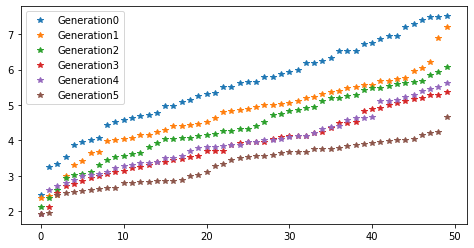

In [109]:
def pattern_cost_function( params ):
    return scipy.linalg.norm( params-np.array([1,5,2.5,2,4,3,0]) )


PN = 7
lb = np.zeros( (PN,) );
ub = 5 + np.zeros( (PN,) );
cost_fcn = pattern_cost_function;
settings = GASettings(numParents=10, numChildren=50)
settings.numGenerations = 5;
settings.eliteCount = 1;
settings.selection = 'linearRanking';
settings.linearRankingRatio = 8;

(params, cost, all_params, all_costs) = GA(pattern_cost_function, lb, ub, settings);

plt.figure( figsize=(8,4) )
legs = []
for i in range(len(all_costs)):
    plt.plot( np.arange(all_costs[i].size), all_costs[i], '*' )
    legs.append( "Generation" + str(i) )
plt.legend( legs );

## Cost function for the Goodwin oscillator

In [110]:
def goodwin_oscillator( t, statevars, params ):
    X = statevars[0];
    Y = statevars[1];
    Z = statevars[2];
    alpha_1 = params[0]
    K = params[1]
    n = params[2]
    gamma_1 = params[3]
    alpha_2 = params[4]
    gamma_2 = params[5]
    alpha_3 = params[6]
    gamma_3 = params[7]
        
    dydt = np.zeros( (3,) )
    dydt[0] = alpha_1*K**n/(K**n+Z**n) - gamma_1*X
    dydt[1] = alpha_2*X - gamma_2*Y;
    dydt[2] = alpha_3*Y - gamma_3*Z;

    return dydt

def get_period(t,x):
    """ Approximate the period of a 1-D x, given the time-steps t.
        Returns a tuple with the period and the standard deviation of the period over time.
        if the value of the standard deviation is not smaller than 0.1, then
        it means the period estimate is dodgy and you shouldn't use it. Instead,
        plot your simulation and figure out why it isn't periodic - maybe it just
        hasn't reached the limit cycle yet."""
    idxs = scipy.signal.find_peaks(x)
    idxs = idxs[0]
    times = t[idxs]
    period = np.mean(np.diff(times));
    sdperiod = np.sqrt(np.var(np.diff(times)));
    return (period,sdperiod)

def goodwin_circadian_error( params, debug=False ):
    mf = lambda t,y : goodwin_oscillator(t,y, params)

    sol1 = scipy.integrate.solve_ivp( fun=mf, t_span=(0,500), y0=(.1,.1,.1) )
    sol2 = scipy.integrate.solve_ivp( fun=mf, t_span=(0,100), y0=sol1.y[:,-1], 
                                    t_eval=np.arange(0,100,.01) )
    # Compute the period of the first state. It is a scalar.
    (period,sdper) = get_period( sol2.t, sol2.y[0,:] )
    # compute the peak-to-trough amp for each state
    # by computing the min and max over time and subtracting.
    # amps will be an ndarray of length 3.
    amps = sol2.y.max(axis=1)-sol2.y.min(axis=1)
    # an amplitude larger than 0.1 is going to have low cost
    # scale the amplitudes and then compute the exponential for
    # each amp. Since log(0.001)<0, the curve will be decreasing
    # as the amplitude is increasing. 
    # amp_errvals will be an ndarray of length 3.
    rate = np.log(0.001)/0.1;
    amp_errvals = np.exp(np.multiply(rate,amps));
    # The amplitude cost is the sum of the 3 amplitude error values.
    acost = amp_errvals.sum()
    # amplitude should not be shrinking or growing
    # compute the 3 amplitudes for the first half of the simulation
    # and then for the second
    half = sol2.y.shape[1]//2
    amps1 = sol2.y[:,:half].max(axis=1)-sol2.y[:,:half].min(axis=1)
    amps2 = sol2.y[:,half:].max(axis=1)-sol2.y[:,half:].min(axis=1)
    if debug:
        print( amps1 )
        print(amps2)
    # sum the amplitudes and take their difference. Then multiply
    # the difference by 100 (to amplify it) and square the result.
    bcost = (100*(amps1.sum()-amps2.sum()))**2
    if debug:
        print((period-24)**2, acost, bcost, amps1.sum(), amps2.sum() )

    # The total cost is the squared difference between the period and 24 hours 
    # plue the two amplitude costs. We weight the acost with 5 because it values
    # tend to be small.
    return (period-24)**2 + 5*acost + bcost

### Run the GA for the Goodwin Oscillator

Run the GA once for a given selection operator. Then plot the costs for each generation.

With 50 parents and 250 kids per generation, this takes Stephanie about 1 minute to run.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.

Best of generation  1  has cost  6.20781966039182
Best of generation  2  has cost  0.1531534671463472
Best of generation  3  has cost  0.03522141805395543
Best of generation  4  has cost  0.03522141805395543
Best of generation  5  has cost  0.017413766926975736


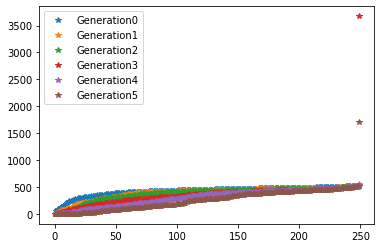

In [111]:
# For reference, here is a set of working parameters.
# I am going to construct the lower and upper bounds of parameter
# space so that they capture these values.
# alpha_1 = 1
# K = 0.61
# n = 11
# gamma_1 = 0.15
# alpha_2 = 1
# gamma_2 = 0.15
# alpha_3 = 1
# gamma_3 = 0.25

param_names = ['alpha_1','K','n','gamma_1','alpha_2','gamma_2','alpha _3','gamma_3']
lb = np.array([0.001,0.001,4,0.001,0.05,0.001,0.05,0.001])
ub = np.array( [2,2,15,1,2,1,2,1])

# We will use more parents and children than with the toy problem.
settings = GASettings(numParents=50, numChildren=250)
settings.numGenerations = 5;
settings.eliteCount = 1;
settings.selection = 'linearRanking';
settings.linearRankingRatio = 8;

# Run algorithm
(params, cost, all_params, all_costs) = GA(goodwin_circadian_error, lb, ub, settings);

# Plot costs
legs = []
for i in range(len(all_costs)):
    plt.plot( np.arange(all_costs[i].size), all_costs[i], '*' )
    legs.append( "Generation" + str(i) )

plt.legend( legs );    

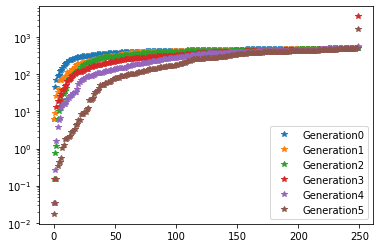

In [112]:
# Re-Plot costs using a log-scale for the y axis.
# This allows us to see the differences a little bit better.
legs = []
for i in range(len(all_costs)):
    plt.semilogy( np.arange(all_costs[i].size), all_costs[i], '*' )
    legs.append( "Generation" + str(i) )
plt.legend( legs );    

## Example analysis of GA with Goodwin Oscillator

Run the GA with linear ranking selection with a ratio of 8. Run the algorithm 5 times, saving the results in .npz files, because this will take awhile.

Subsequent cells read in the files and plot the results.

In [113]:
# For reference, here is a set of working parameters.
# I am going to construct the lower and upper bounds of parameter
# space so that they capture these values.
# alpha_1 = 1
# K = 0.61
# n = 11
# gamma_1 = 0.15
# alpha_2 = 1
# gamma_2 = 0.15
# alpha_3 = 1
# gamma_3 = 0.25

param_names = ['alpha_1','K','n','gamma_1','alpha_2','gamma_2','alpha _3','gamma_3']
lb = np.array([0.001,0.001,4,0.001,0.05,0.001,0.05,0.001])
ub = np.array( [2,2,15,1,2,1,2,1])

# We will use more parents and children than with the toy problem.
settings = GASettings(numParents=100, numChildren=500)
settings.numGenerations = 5;
settings.eliteCount = 1;
settings.selection = 'linearRanking';
settings.linearRankingRatio = 8;

for runNum in range(1,6):
    fn = "Goodwin_linearRanking%d_run%d.npz" % (settings.linearRankingRatio,runNum)
    if os.path.isfile( fn ):
        continue

    (params, cost, all_params, all_costs) = GA(goodwin_circadian_error, lb, ub, settings);
    np.savez( fn, params=params, cost=cost, all_params=all_params, all_costs=all_costs )

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.

Best of generation  1  has cost  0.9731257633736008
Best of generation  2  has cost  0.07748979686537318
Best of generation  3  has cost  0.07748979686537318


<ipython-input-110-ae063578db5a>:15: RuntimeWarning: invalid value encountered in double_scalars
  dydt[0] = alpha_1*K**n/(K**n+Z**n) - gamma_1*X


Best of generation  4  has cost  0.07748979686537318
Best of generation  5  has cost  0.02281470778521827
Best of generation  1  has cost  1.3623368307138033
Best of generation  2  has cost  0.21375072797159198
Best of generation  3  has cost  0.21375072797159198
Best of generation  4  has cost  0.21375072797159198
Best of generation  5  has cost  0.009221448866046818
Best of generation  1  has cost  0.38471531154433974
Best of generation  2  has cost  0.38471531154433974
Best of generation  3  has cost  0.1415160963585752
Best of generation  4  has cost  0.1415160963585752
Best of generation  5  has cost  0.1415160963585752
Best of generation  1  has cost  2.0953413800133185
Best of generation  2  has cost  2.0953413800133185
Best of generation  3  has cost  0.044496756982869305
Best of generation  4  has cost  0.044496756982869305
Best of generation  5  has cost  0.044496756982869305
Best of generation  1  has cost  5.091104104289987
Best of generation  2  has cost  0.317379883593722

### Plot the costs for each generation for all 5 runs of a GA

For a given tournament size, read in the files with GA results and plot the costs for each generation in a subplot.

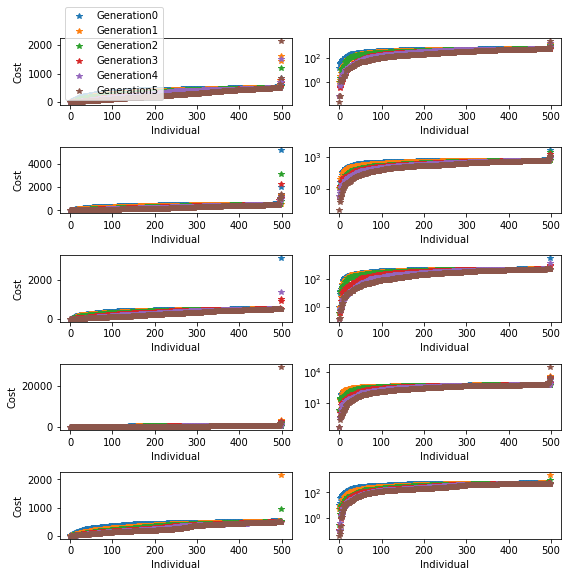

In [114]:
lr_Ratio = 8

plt.figure( figsize=(8,8) )
for runNum in range(1,6):
    plt.subplot( 5, 2, (runNum-1)*2+1 )
    fn = "Goodwin_linearRanking%d_run%d.npz" % (lr_Ratio,runNum)
    f = np.load( fn, allow_pickle=True )
    all_costs = f['all_costs']
    all_params = f['all_params']
    legs = []
    for i in range(len(all_costs)):
        plt.plot( np.arange(all_costs[i].size), all_costs[i], '*' )
        legs.append( "Generation" + str(i) )
    plt.ylabel( "Cost")
    plt.xlabel( 'Individual')

    if runNum == 1:
        plt.legend( legs );    
    plt.subplot( 5, 2, (runNum-1)*2+2 )
    for i in range(len(all_costs)):
        plt.semilogy( np.arange(all_costs[i].size), all_costs[i], '*' )
    plt.xlabel( 'Individual')


plt.tight_layout()

### Plot results from a single GA run

Load in the run, then plot the costs for each generation in one figure. Then, plot the values of the parameters in a jitter plot. Construct the jitter plot so that we can adjust the a threshold so that we can include parameters from all children or just those from children with costs below the threshold.

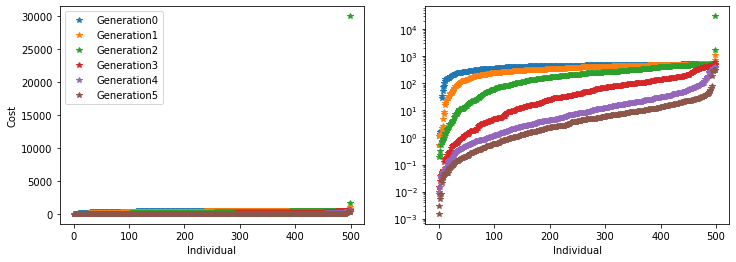

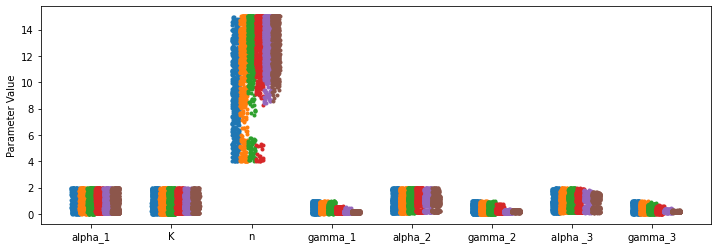

In [76]:
runNum = 2
tournamentSize = 5
fn = "Goodwin_tournament%d_run%d.npz" %(tournamentSize,runNum)
f = np.load( fn, allow_pickle=True )
all_costs = f['all_costs']
all_params = f['all_params']
params = f['params']
cost = f['cost']

plt.figure( figsize=(12,4) )
plt.subplot( 1, 2, 1 )
legs = []
for i in range(len(all_costs)):
    plt.plot( np.arange(all_costs[i].size), all_costs[i], '*' )
    legs.append( "Generation" + str(i) )
plt.legend( legs );
plt.ylabel("Cost")
plt.xlabel("Individual")
plt.subplot( 1, 2, 2 )
for i in range(len(all_costs)):
    plt.semilogy( np.arange(all_costs[i].size), all_costs[i], '*' )
plt.xlabel("Individual")

plt.figure(figsize=(12,4));
PN = lb.size
dp = 1/(2*settings.numGenerations)
cost_threshold = np.inf #5

for g in range(settings.numGenerations+1):
    idx = all_costs[g] < cost_threshold
    for i in range(lb.size):
        plt.plot( i+g*dp + np.random.rand(np.count_nonzero(idx))*dp, all_params[g][idx,i], '.C'+ str(g))
plt.xticks( ticks=np.arange(0,PN)+0.25, labels=param_names);
plt.ylabel( "Parameter Value");

Plot the simulation from the best individual in the GA run we have been studying.

alpha_1 : 0.8205447402924716
K : 0.47903044097377767
n : 14.255274697239507
gamma_1 : 0.18387237605656992
alpha_2 : 0.8696674455635882
gamma_2 : 0.18991037604502864
alpha _3 : 1.0894937827638904
gamma_3 : 0.1930820228413166


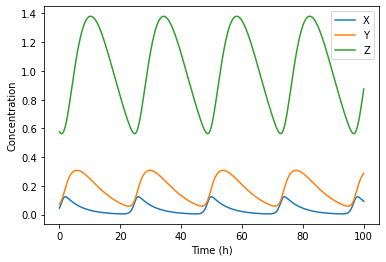

In [77]:
mf = lambda t,y : goodwin_oscillator(t,y, params)

sol1 = scipy.integrate.solve_ivp( fun=mf, t_span=(0,500), y0=(.1,.1,.1) )
sol2 = scipy.integrate.solve_ivp( fun=mf, t_span=(0,100), y0=sol1.y[:,-1], 
                                t_eval=np.arange(0,100,.01) )

plt.figure()
plt.plot( sol2.t, sol2.y.T );
plt.xlabel( "Time (h)")
plt.ylabel( "Concentration")
plt.legend( ['X','Y','Z'])

for i in range(len(params)):
    print(param_names[i], ':', params[i])


## Bonus Code
This is the code I used to generate the figures for lecture.

First, plot the probability distribution for linear ranking selection when we are selecting from a previous generation with 50 individuals.

[0.032      0.0315102  0.03102041 0.03053061 0.03004082 0.02955102
 0.02906122 0.02857143 0.02808163 0.02759184 0.02710204 0.02661224
 0.02612245 0.02563265 0.02514286 0.02465306 0.02416327 0.02367347
 0.02318367 0.02269388 0.02220408 0.02171429 0.02122449 0.02073469
 0.0202449  0.0197551  0.01926531 0.01877551 0.01828571 0.01779592
 0.01730612 0.01681633 0.01632653 0.01583673 0.01534694 0.01485714
 0.01436735 0.01387755 0.01338776 0.01289796 0.01240816 0.01191837
 0.01142857 0.01093878 0.01044898 0.00995918 0.00946939 0.00897959
 0.0084898  0.008     ]


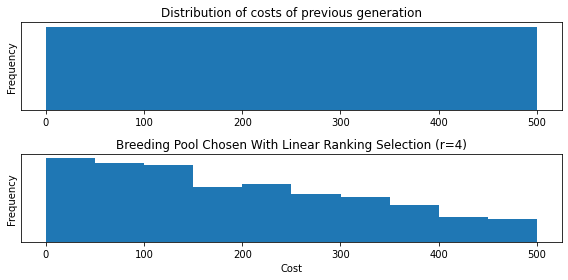

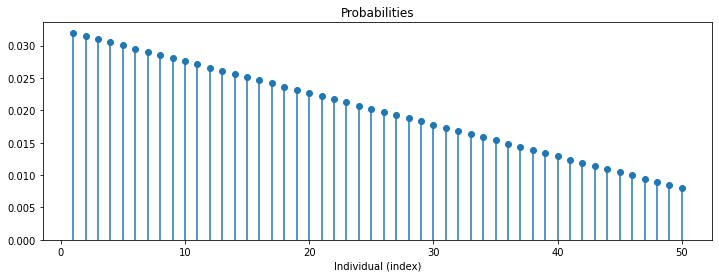

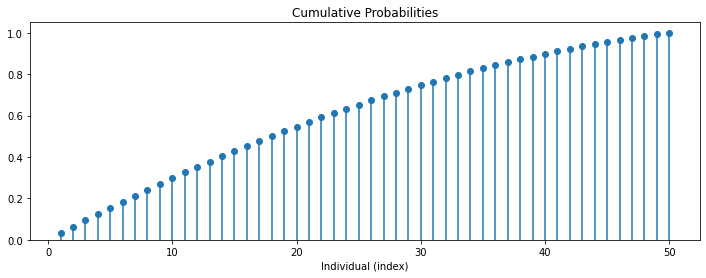

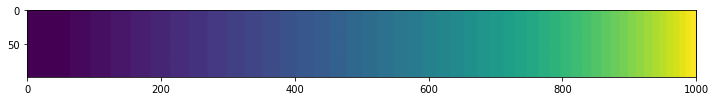

In [126]:
lam = 50 # number of individuals in generation
mu = 1000 # number of individuals in breeding pool
G = np.zeros( (lam,NP) )
for i in range(lam):
    G[i,:] = i
Gcost = np.linspace(0.1,500,lam)
settings = GASettings(numParents=mu, numChildren=lam)

settings.selection = 'linearRanking'
settings.linearRankingRatio = 4
(P, Pcost) = select_pool(G, Gcost, settings)
plt.figure( figsize=(8,4) )
plt.subplot(2,1,1)
plt.hist(Gcost)
plt.ylabel('Frequency')
plt.yticks([])

plt.title( "Distribution of costs of previous generation")
plt.subplot(2,1,2)
plt.hist( Pcost );
plt.title( "Breeding Pool Chosen With Linear Ranking Selection (r=4)")
plt.xlabel( 'Cost')
plt.ylabel('Frequency')
plt.yticks([])
plt.tight_layout()

r = settings.linearRankingRatio
n = lam
pn = 2/n*(1/(1+r))
p1 = r*pn

ps = np.zeros((n,))
for i in range(1,n+1):
    ps[i-1] = pn + (p1-pn)*(n-i)/(n-1)
    
plt.figure(figsize=(12,4));
plt.plot( np.arange(1,n+1), ps, 'oC0')
for i in range(n):
    plt.plot( [i+1,i+1],[0, ps[i]],'C0')
yl = plt.ylim()
plt.ylim((0,yl[1]))
plt.title( "Probabilities")
plt.xlabel( "Individual (index)")
    
plt.figure(figsize=(12,4));
cs = ps.cumsum()
plt.plot( np.arange(1,n+1), cs, 'oC0')
for i in range(n):
    plt.plot( [i+1,i+1],[0, cs[i]],'C0')
yl = plt.ylim()
plt.ylim((0,yl[1]))
plt.title('Cumulative Probabilities')
plt.xlabel( "Individual (index)")

plt.figure(figsize=(12,4))
mat = np.zeros((100,1001))
idxs = np.array(np.round(1000*cs),np.int)
for i in range(len(idxs)-1):
    mat[:,idxs[i]:idxs[i+1]] = i/n
plt.imshow( mat )
print(ps)

Then plot it for just 4 so we can put the numbers in text.

[0.33333333 0.27777778 0.22222222 0.16666667]
[ 333  611  833 1000]


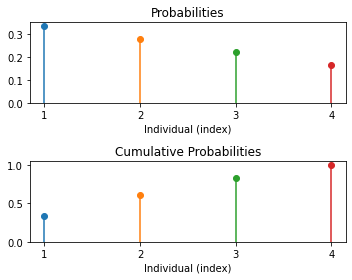

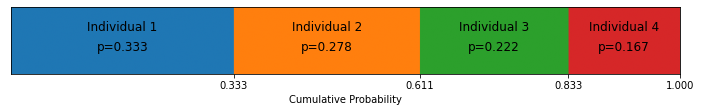

In [76]:
r = 2
n = 4
pn = 2/n*(1/(1+r))
p1 = r*pn

ps = np.zeros((n,))
for i in range(1,n+1):
    ps[i-1] = pn + (p1-pn)*(n-i)/(n-1)
    
plt.figure(figsize=(5,4));
plt.subplot(2,1,1)

for i in range(n):
    plt.plot( i+1, ps[i], 'oC'+str(i))
    plt.plot( [i+1,i+1],[0, ps[i]],'C'+str(i))

yl = plt.ylim()
plt.ylim((0,yl[1]))
plt.title( "Probabilities")
plt.xlabel( "Individual (index)")
plt.xticks(np.arange(1,n+1))
    
plt.subplot(2,1,2)
cs = ps.cumsum()
for i in range(n):
    plt.plot( i+1, cs[i], 'oC'+str(i))
    plt.plot( [i+1,i+1],[0, cs[i]],'C'+str(i))
yl = plt.ylim()
plt.ylim((0,yl[1]))
plt.title('Cumulative Probabilities')
plt.xlabel( "Individual (index)")
plt.xticks(np.arange(1,n+1))
plt.tight_layout()


plt.figure(figsize=(12,4))
cmap = matplotlib.cm.get_cmap('tab10')
mat = np.zeros((100,1001,4))
idxs = np.array(np.round(1000*cs),np.int)
for i in range(len(idxs)):
    if i == 0:
        mat[:,0:idxs[i],:] = cmap(i)
    else:
        mat[:,idxs[i-1]:idxs[i],:] = cmap(i)
plt.imshow( mat )
labs = []
for i in range(n):
    if i == 0:
        x = idxs[0]/2
    else:
        x = (idxs[i-1]+idxs[i])/2
    plt.text( x, 35, 'Individual %d' % (i+1), horizontalalignment='center', fontsize=12)
    plt.text( x, 65, 'p=%0.3f' % ps[i], horizontalalignment='center', fontsize=12)
    labs.append('%0.3f'%cs[i])
plt.xticks( idxs, labs )
plt.yticks([])
plt.xlabel( 'Cumulative Probability')

print(ps)
print(idxs)

1.3333333333333333 0.6666666666666666


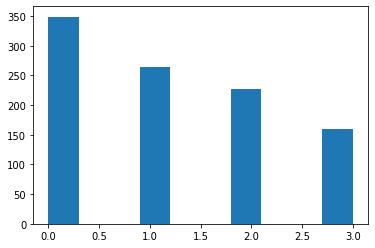

In [96]:
numTrials = 1000
idxs = np.zeros((numTrials,))
for i in range( numTrials ):
    num = np.random.random() # number between 0 and 1, from uniform distribution
    idxs[i] = np.argmax( num < cs )

plt.hist(idxs);

print(ps[0]*n,ps[-1]*n)